In [17]:
import os
for dirname, _, filenames in os.walk('kaggle\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle\input\tabular-playground-series-jul-2021\sample_submission.csv
kaggle\input\tabular-playground-series-jul-2021\test.csv
kaggle\input\tabular-playground-series-jul-2021\train.csv


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # numeric scaling
from sklearn.metrics import mean_squared_log_error # Metric for the competition
from catboost import CatBoostRegressor # Our model of choice
from sklearn.model_selection import GridSearchCV # Model tuning

In [19]:
df_train = pd.read_csv("kaggle/input/tabular-playground-series-jul-2021/train.csv")
df_train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [20]:
df_test = pd.read_csv("kaggle/input/tabular-playground-series-jul-2021/test.csv")
df_test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [21]:
df_train.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB


In [22]:
df_test.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          2247 non-null   object 
 1   deg_C              2247 non-null   float64
 2   relative_humidity  2247 non-null   float64
 3   absolute_humidity  2247 non-null   float64
 4   sensor_1           2247 non-null   float64
 5   sensor_2           2247 non-null   float64
 6   sensor_3           2247 non-null   float64
 7   sensor_4           2247 non-null   float64
 8   sensor_5           2247 non-null   float64
dtypes: float64(8), object(1)
memory usage: 158.1+ KB


In [23]:
print("Null values in training set: ", df_train.isnull().sum().sum())
print("Null values in testing set: ", df_test.isnull().sum().sum())

Null values in training set:  0
Null values in testing set:  0


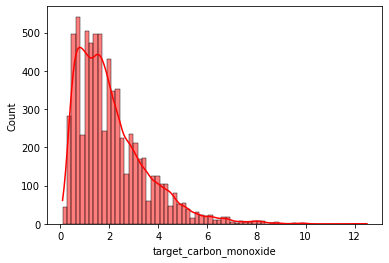

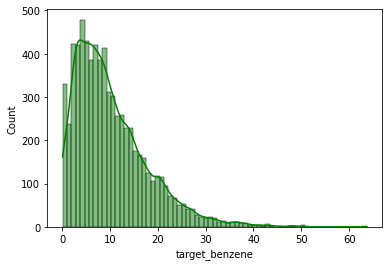

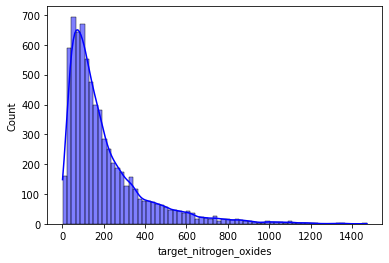

In [24]:
sns.histplot(df_train['target_carbon_monoxide'], color="red", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });
plt.show()
sns.histplot(df_train['target_benzene'], color="green", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });
plt.show()
sns.histplot(df_train['target_nitrogen_oxides'], color="blue", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });

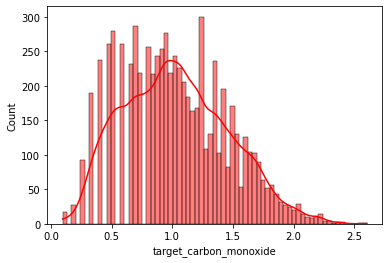

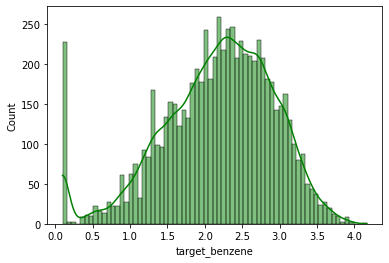

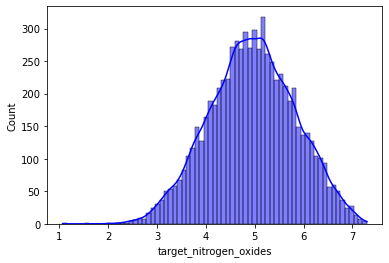

In [25]:
sns.histplot(np.log1p(df_train['target_carbon_monoxide']), color="red", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });
plt.show()
sns.histplot(np.log1p(df_train['target_benzene']), color="green", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });
plt.show()
sns.histplot(np.log1p(df_train['target_nitrogen_oxides']), color="blue", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });

In [26]:
X_train = df_train.drop(["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"], axis=1).copy()
y_train = df_train[ ["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"] ].copy()
y_train_log1p = pd.DataFrame(np.log1p(y_train))
X_test = df_test.copy()

In [27]:
for df in [X_train, X_test]:
    df['date_time'] = df['date_time'].astype('datetime64[ns]').astype(np.int64)

In [28]:
numeric_features = X_train.select_dtypes(exclude=["object"]).columns

In [29]:
scaler = StandardScaler()

X_train_scaled = X_train
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = X_test
X_test_scaled[numeric_features] = scaler.fit_transform(X_test[numeric_features])

In [30]:
# hyperparameters previously found with grid search
models = [None, None, None]
params = [
    {"depth": 2, "learning_rate": 0.1}, 
    {"depth": 2, "learning_rate": 0.1}, 
    {"depth": 2, "learning_rate": 0.1}
]

for i in range(len(models)):
    #################### UNCOMMENT TO RUN GRID SEARCH ####################
    # models[i] = CatBoostRegressor(iterations=500, cat_features=categorical_features, loss_function="MAE", logging_level="Silent")

    # # Change these values to tweak the model
    # grid = {"learning_rate": [0.001, 0.01, 0.05, 0.1, 0.5, 1], "depth": [2,3,4]}

    # grid_search_result = models[i].grid_search(grid, X=X_train, y=y_train_log1p.iloc[:, i])
    # params[i]["depth"] = grid_search_result["params"]["depth"]
    # params[i]["learning_rate"] = grid_search_result["params"]["learning_rate"]
    # print(grid_search_result["params"])
    ######################################################################

    # I've found that adding iterations improves my score rapidly
    # past this point I will have highly diminishing returns
    models[i] = CatBoostRegressor(iterations=5000, learning_rate=params[i]["learning_rate"], \
                                depth=params[i]["depth"], loss_function="MAE", logging_level="Silent")

    models[i].fit(X_train_scaled, y_train_log1p.iloc[:, i]);

In [31]:
train_predictions = np.expm1([model.predict(X_train_scaled) for model in models]).T
print("Score on training set: ", mean_squared_log_error(y_train, train_predictions))

Score on training set:  0.018314235534026113


In [32]:
# Output submission csv as detailed in Kaggle.
test_predictions = np.expm1([model.predict(X_test_scaled) for model in models]).T
solution = pd.DataFrame( { 
    "date_time": df_test.date_time, 
    "target_carbon_monoxide": test_predictions[:, 0],
    "target_benzene": test_predictions[:, 1],
    "target_nitrogen_oxides": test_predictions[:, 2]
     } )
solution.to_csv("submissions\submissionCatboost.csv", index = False)